# Steps in this Notebook

1. Imports
2. Snowflake Setup
3. TS Forecasting with DARTS
4. TS Forecasting with SKTIME - https://github.com/sktime/sktime/tree/main/examples

# Imports

In [108]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.types as T
import snowflake.snowpark.functions as F
from snowflake.snowpark.functions import col

from snowflake.snowpark.functions import udf
from snowflake.snowpark.types import IntegerType, FloatType, StringType,StructType, StructField

import snowflake.ml.modeling.preprocessing as snowml
from snowflake.ml.modeling.xgboost import XGBClassifier
from snowflake.ml.modeling.preprocessing import KBinsDiscretizer, OrdinalEncoder, OneHotEncoder
from snowflake.ml.modeling.impute import SimpleImputer

import json
import pandas as pd
from datetime import date, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [109]:
connection_parameters = json.load(open('/Users/skhara/Documents/GitHub/creds.json'))
session = Session.builder.configs(connection_parameters).create()

# Snowflake Setup: Create a Database and Schema

We will be using PUBLIC schema.

In [110]:
session.sql('USE DATABASE TIME_SERIES').collect()
session.sql('USE SCHEMA POC_INVISTA').collect()

[Row(status='Statement executed successfully.')]

In [111]:
# Load TS data from Store_Traffic Database into ACCRUENT_TS_FORECASTING DB for testing purposes.
sdf_raw = session.table('TIME_SERIES.POC_INVISTA.TIME_SERIES_DATA')

In [112]:
# Print the Number of Time Series/Pumps that we have to predict
session.sql('SELECT COUNT(DISTINCT PUMP_ID) FROM TIME_SERIES_DATA').collect()

[Row(COUNT(DISTINCT PUMP_ID)=1000)]

In [113]:
# Print the PUMP_ID and Start and End date of Time Series
session.sql('SELECT PUMP_ID, MIN(TIMESTAMP), MAX(TIMESTAMP) FROM TIME_SERIES_DATA GROUP BY PUMP_ID').collect()

[Row(PUMP_ID=1, MIN(TIMESTAMP)=datetime.date(2018, 1, 1), MAX(TIMESTAMP)=datetime.date(2023, 8, 8)),
 Row(PUMP_ID=2, MIN(TIMESTAMP)=datetime.date(2018, 1, 1), MAX(TIMESTAMP)=datetime.date(2023, 8, 8)),
 Row(PUMP_ID=3, MIN(TIMESTAMP)=datetime.date(2018, 1, 1), MAX(TIMESTAMP)=datetime.date(2023, 8, 8)),
 Row(PUMP_ID=4, MIN(TIMESTAMP)=datetime.date(2018, 1, 1), MAX(TIMESTAMP)=datetime.date(2023, 8, 8)),
 Row(PUMP_ID=5, MIN(TIMESTAMP)=datetime.date(2018, 1, 1), MAX(TIMESTAMP)=datetime.date(2023, 8, 8)),
 Row(PUMP_ID=6, MIN(TIMESTAMP)=datetime.date(2018, 1, 1), MAX(TIMESTAMP)=datetime.date(2023, 8, 8)),
 Row(PUMP_ID=7, MIN(TIMESTAMP)=datetime.date(2018, 1, 1), MAX(TIMESTAMP)=datetime.date(2023, 8, 8)),
 Row(PUMP_ID=9, MIN(TIMESTAMP)=datetime.date(2018, 1, 1), MAX(TIMESTAMP)=datetime.date(2023, 8, 8)),
 Row(PUMP_ID=10, MIN(TIMESTAMP)=datetime.date(2018, 1, 1), MAX(TIMESTAMP)=datetime.date(2023, 8, 8)),
 Row(PUMP_ID=11, MIN(TIMESTAMP)=datetime.date(2018, 1, 1), MAX(TIMESTAMP)=datetime.date(20

In [114]:
sdf_raw.limit(5).to_pandas()

,TIMESTAMP,PUMP_ID,VALUE
0,2018-01-01,1,119
1,2018-01-02,1,138
2,2018-01-03,1,134
3,2018-01-04,1,124
4,2018-01-05,1,103


In [115]:
sdf_raw.describe().collect()

[Row(SUMMARY='count', PUMP_ID=2046000.0, VALUE=2046000.0),
 Row(SUMMARY='mean', PUMP_ID=500.5, VALUE=124.109512),
 Row(SUMMARY='stddev', PUMP_ID=288.67506080366553, VALUE=35.57537708865502),
 Row(SUMMARY='min', PUMP_ID=1.0, VALUE=44.0),
 Row(SUMMARY='max', PUMP_ID=1000.0, VALUE=246.0)]

# Local Testing

In [116]:
df_data = sdf_raw.filter((F.col("PUMP_ID") == 62)).to_pandas()

df_data['TIMESTAMP'] = pd.to_datetime(df_data['TIMESTAMP'])
df_data = df_data.groupby('TIMESTAMP').sum('VALUE').reset_index()
df_data = df_data[['TIMESTAMP','VALUE']]
df_data = df_data.sort_values(by=['TIMESTAMP']).reset_index(drop=True)

In [117]:
df_data.head()

,TIMESTAMP,VALUE
0,2018-01-01,119
1,2018-01-02,138
2,2018-01-03,133
3,2018-01-04,124
4,2018-01-05,103


### Testing with Sktime Locally

In [32]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split

from sktime.forecasting.theta import ThetaForecaster
from sklearn.ensemble import RandomForestRegressor

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

In [29]:
df_input = pd.Series(df_data['VALUE'].values, index=df_data['TIMESTAMP'])
df_input.index.freq = 'D'  # Set this to the appropriate frequency
df_input = df_input.resample('D').asfreq()  # Resample if needed; adjust the 'M' if using a different frequency

In [34]:
y_train, y_test = temporal_train_test_split(df_input)
fh = ForecastingHorizon(y_test.index, is_relative=False)

In [35]:
forecaster = ThetaForecaster(sp=12)  # monthly seasonal periodicity
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
mean_absolute_percentage_error(y_test, y_pred)

0.0888130877494323

### Testing with Dart Locally

In [ ]:
# !pip install darts

In [38]:
import darts
from darts import TimeSeries
from darts.models import FFT
from darts.metrics import mae, mape

The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `Prophet` module could not be imported. To enable Prophet support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `CatBoost` module could not be imported. To enable CatBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


In [44]:
#Train + Forecast Length
train_length = 600
forecast_horizon = 30

train_end = max(df_data['TIMESTAMP']) - pd.Timedelta(days = 30)
train_start = train_end - pd.Timedelta(days = 600)
df_input = df_data.loc[(df_data['TIMESTAMP'] >= train_start) &
                        (df_data['TIMESTAMP'] < train_end)].reset_index(drop=True)
df_input = df_input.set_index('TIMESTAMP')
df_input.index.name = 'time'

ts_train = TimeSeries.from_dataframe(df_input, fill_missing_dates=True, freq='D')
ts_train

<TimeSeries (DataArray) (time: 600, component: 1, sample: 1)>
array([[[184.]],

       [[184.]],

       [[170.]],

       [[149.]],

       [[133.]],

       [[141.]],

       [[155.]],

       [[174.]],

       [[184.]],

       [[174.]],

...

       [[194.]],

       [[173.]],

       [[150.]],

       [[154.]],

       [[177.]],

       [[190.]],

       [[196.]],

       [[185.]],

       [[167.]],

       [[156.]]])
Coordinates:
  * time       (time) datetime64[ns] 2021-11-16 2021-11-17 ... 2023-07-08
  * component  (component) object 'VALUE'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [45]:
from darts.models import XGBModel
my_model = XGBModel(lags = 10, n_estimators=100, max_depth=5)
my_model.fit(ts_train)

XGBModel(lags=10, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True, n_estimators=100, max_depth=5)

In [46]:
ts_forecast = my_model.predict(31)
data = ts_forecast.pd_dataframe().reset_index().values
df_forecasted = pd.DataFrame(data, columns = ['TIMESTAMP','FORECAST'])
df_forecasted

,TIMESTAMP,FORECAST
0,2023-07-09,154.098129
1,2023-07-10,177.000229
2,2023-07-11,194.219437
3,2023-07-12,196.041092
4,2023-07-13,178.886414
5,2023-07-14,167.056152
6,2023-07-15,153.515213
7,2023-07-16,153.075653
8,2023-07-17,177.338379
9,2023-07-18,195.800369


<Axes: xlabel='TIMESTAMP'>

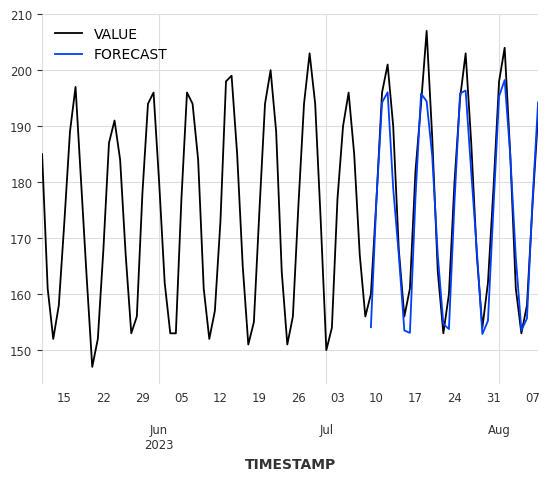

In [47]:
df_compare = df_data.merge(df_forecasted, how='left', left_on='TIMESTAMP', right_on='TIMESTAMP')
df_compare = df_compare.set_index('TIMESTAMP')
df_compare.iloc[-90:].plot()

In [48]:
df_res = df_compare.dropna()
df_res = (df_res['VALUE'] - df_res['FORECAST'])/df_res['VALUE'] * 100
print('MAPE= ',df_res.mean())

MAPE=  1.440664665036803


### Darts + SKTime in One

In [ ]:
from sktime.forecasting.theta import ThetaForecaster
from sklearn.ensemble import RandomForestRegressor

from darts.models import XGBModel
from darts.models import FFT
from darts import TimeSeries

In [92]:
# Load Data
df_data = sdf_raw.filter((F.col("PUMP_ID") == 62)).to_pandas()

df_data['TIMESTAMP'] = pd.to_datetime(df_data['TIMESTAMP'])
df_data = df_data.groupby('TIMESTAMP').sum('VALUE').reset_index()
df_data = df_data[['TIMESTAMP','VALUE']]
df_data = df_data.sort_values(by=['TIMESTAMP']).reset_index(drop=True)

In [135]:
from darts import TimeSeries
from darts.models import RandomForest
from darts.models import XGBModel
from darts.models import FFT

import xgboost
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.base import ForecastingHorizon

df_input = df_data.copy()
df_input['TIMESTAMP'] = pd.to_datetime(df_input['TIMESTAMP'])
df_input = df_input.groupby('TIMESTAMP').sum('VALUE').reset_index()
df_input = df_input[['TIMESTAMP','VALUE']]
df_input = df_input.sort_values(by=['TIMESTAMP']).reset_index(drop=True)

#Train + Forecast Length
train_length = 600
forecast_horizon = 30

train_end = max(df_input['TIMESTAMP']) - pd.Timedelta(days = forecast_horizon)
train_start = train_end - pd.Timedelta(days = train_length)
forecast_end = train_end + pd.Timedelta(days = forecast_horizon)
df_input = df_input.loc[(df_input['TIMESTAMP'] >= train_start) &
                        (df_input['TIMESTAMP'] < train_end)].reset_index(drop=True)

# Initialize df_forecasts that will contain results of all models
df_forecasts = pd.DataFrame()

def model_sktime(df, model, model_name):
    # SKTIME Stuff
    df_sktime = pd.Series(df['VALUE'].values, index=df['TIMESTAMP'])
    df_sktime.index.freq = 'D'  # Set this to the appropriate frequency
    df_sktime = df_sktime.resample('D').asfreq()  # Resample if needed; adjust the 'M' if using a monthly frequency
    
    fh = ForecastingHorizon(pd.date_range(start = train_end, end = forecast_end), is_relative=False)

    # Fit and predict
    df_output = model.fit(df_sktime).predict(fh)
    df_output = df_output.to_frame().reset_index()
    df_output.columns = ['TIMESTAMP','FORECAST']
    df_output['MODEL'] = model_name
    return df_output

def model_darts(df, model, model_name):
    df_darts = df.set_index('TIMESTAMP')
    df_darts.index.name = 'time'
    ts_darts = TimeSeries.from_dataframe(df_darts, fill_missing_dates=True, freq='D')

    # Fit and predict
    ts_forecast = model.fit(ts_darts).predict(forecast_horizon+1)
    data = ts_forecast.pd_dataframe().reset_index().values
    df_output = pd.DataFrame(data, columns = ['TIMESTAMP','FORECAST'])
    df_output['MODEL'] = model_name
    return df_output

model = ThetaForecaster(sp=12)  # monthly seasonal periodicity
df_out = model_sktime(df_input, model, 'sktime_theta_forecaster')
df_forecasts = df_forecasts.append(df_out, ignore_index = True)

model = XGBModel(lags = 10, n_estimators=100, max_depth=5)
df_out = model_darts(df_input, model, 'darts_xgboost')
df_forecasts = df_forecasts.append(df_out, ignore_index = True)

model = FFT(nr_freqs_to_keep=400,trend=None)
df_out = model_darts(df_input, model, 'darts_fft')
df_forecasts = df_forecasts.append(df_out, ignore_index = True)

model = RandomForest(lags = 10, n_estimators=100, max_depth=5)
df_out = model_darts(df_input, model, 'darts_random_forest')
df_forecasts = df_forecasts.append(df_out, ignore_index = True)

# Processing
df_forecasts['TRAIN_START'] = train_start
df_forecasts['TRAIN_END'] = train_end
df_forecasts['FORECAST_HORIZON'] = forecast_horizon

df_forecasts

No matching timestamp could be found, returning original TimeSeries.


,TIMESTAMP,FORECAST,MODEL,TRAIN_START,TRAIN_END,FORECAST_HORIZON
0,2023-07-09,156.532274,sktime_theta_forecaster,2021-11-16,2023-07-09,30
1,2023-07-10,156.346064,sktime_theta_forecaster,2021-11-16,2023-07-09,30
2,2023-07-11,156.031618,sktime_theta_forecaster,2021-11-16,2023-07-09,30
3,2023-07-12,156.351375,sktime_theta_forecaster,2021-11-16,2023-07-09,30
4,2023-07-13,156.327963,sktime_theta_forecaster,2021-11-16,2023-07-09,30
...,...,...,...,...,...,...
119,2023-08-04,166.116385,darts_random_forest,2021-11-16,2023-07-09,30
120,2023-08-05,150.208559,darts_random_forest,2021-11-16,2023-07-09,30
121,2023-08-06,153.807384,darts_random_forest,2021-11-16,2023-07-09,30
122,2023-08-07,174.036615,darts_random_forest,2021-11-16,2023-07-09,30


# Creating UDTF for multi-node parallelized model training

### Upload library to Snowflake Stage
We are uploading to a stage as this library is not available through the Snowflake Anaconda Channel.

In [118]:
import nfoursid
nfoursid_path = nfoursid.__path__[0]
print(nfoursid_path)

/Users/skhara/anaconda3/envs/pysnowpark_ml_09_2023/lib/python3.9/site-packages/nfoursid


In [119]:
import darts
darts_path = darts.__path__[0]
print(darts_path)

/Users/skhara/anaconda3/envs/pysnowpark_ml_09_2023/lib/python3.9/site-packages/darts


## - UDTF with SKTIME + DARTS

In [136]:
schema = T.StructType([
    T.StructField("TIMESTAMP", T.DateType()),
    T.StructField("FORECAST", T.IntegerType()),
    T.StructField("MODEL_NAME", T.StringType()),
    T.StructField("TRAIN_START", T.DateType()),
    T.StructField("TRAIN_END", T.DateType()),
    T.StructField("FORECAST_HORIZON", T.IntegerType())
])

@F.udtf(output_schema = schema,
        input_types = [T.VariantType()],
        name = "TS_FORECASTING_MULTI", is_permanent=True, stage_location="@ML_MODELS", session=session,
        packages=['pandas', 'fsspec==2023.4.0','holidays==0.18',
                  'joblib==1.2.0','lightning-utilities==0.7.1','matplotlib==3.7.1',
                  'plotly==5.9.0','pmdarima==2.0.3','pytorch==2.0.1',
                  'pytorch-lightning==2.0.3','pyyaml==6.0','scikit-learn==1.2.2',
                  'scipy==1.10.1','snowflake-snowpark-python==1.4.0','statsmodels',
                  'tbats==1.1.3','torchmetrics==0.11.4','tqdm','xarray', 'sktime', 'xgboost'
                 ], replace=True,
        imports = ["@ML_MODELS/nfoursid.zip", "@ML_MODELS/darts.zip"])

class forecast:
    def __init__(self):
        self.rows=[]
        self.dfs=[]
    
    def process(self, data):
        self.rows.append(data)

        # Merge rows into a dataframe
        if len(self.rows) >= 16000:
            df = pd.DataFrame(self.rows)
            self.dfs.append(df)
            self.rows = []
        
        # Merge dataframes into a single dataframe
        # Minimizes memory footprint
        if len(self.dfs) >= 100:
            merged_df = pd.concat(self.dfs)
            self.dfs = [merged_df]

        yield None
    
    def end_partition(self):
        # Merge any remaining rows
        from darts import TimeSeries
        from darts.models import RandomForest
        from darts.models import XGBModel
        from darts.models import FFT
        
        import xgboost
        from sktime.forecasting.theta import ThetaForecaster
        from sktime.forecasting.base import ForecastingHorizon

        if len(self.rows) > 0:
            df = pd.DataFrame(self.rows)
            self.dfs.append(df)
            self.rows = []
        
        # Process Input
        df_input = pd.concat(self.dfs)
        df_input['TIMESTAMP'] = pd.to_datetime(df_input['TIMESTAMP'])
        df_input = df_input.groupby('TIMESTAMP').sum('VALUE').reset_index()
        df_input = df_input[['TIMESTAMP','VALUE']]
        df_input = df_input.sort_values(by=['TIMESTAMP']).reset_index(drop=True)

        #Train + Forecast Length
        train_length = 600
        forecast_horizon = 30
        
        train_end = max(df_input['TIMESTAMP']) - pd.Timedelta(days = forecast_horizon)
        train_start = train_end - pd.Timedelta(days = train_length)
        forecast_end = train_end + pd.Timedelta(days = forecast_horizon)
        df_input = df_input.loc[(df_input['TIMESTAMP'] >= train_start) &
                                (df_input['TIMESTAMP'] < train_end)].reset_index(drop=True)
        
        # Initialize df_forecasts that will contain results of all models
        df_forecasts = pd.DataFrame()

        def model_sktime(df, model, model_name):
            # SKTIME Stuff
            df_sktime = pd.Series(df['VALUE'].values, index=df['TIMESTAMP'])
            df_sktime.index.freq = 'D'  # Set this to the appropriate frequency
            df_sktime = df_sktime.resample('D').asfreq()  # Resample if needed; adjust the 'M' if using a monthly frequency
            
            fh = ForecastingHorizon(pd.date_range(start = train_end, end = forecast_end), is_relative=False)

            # Fit and predict
            df_output = model.fit(df_sktime).predict(fh)
            df_output = df_output.to_frame().reset_index()
            df_output.columns = ['TIMESTAMP','FORECAST']
            df_output['MODEL'] = model_name
            return df_output
        
        def model_darts(df, model, model_name):
            df_darts = df.set_index('TIMESTAMP')
            df_darts.index.name = 'time'
            ts_darts = TimeSeries.from_dataframe(df_darts, fill_missing_dates=True, freq='D')

            # Fit and predict
            ts_forecast = model.fit(ts_darts).predict(forecast_horizon+1)
            data = ts_forecast.pd_dataframe().reset_index().values
            df_output = pd.DataFrame(data, columns = ['TIMESTAMP','FORECAST'])
            df_output['MODEL'] = model_name
            return df_output

        # Theta Forecaster
        model = ThetaForecaster(sp=52)  # weekly seasonal periodicity
        df_out = model_sktime(df_input, model, 'sktime_theta_forecaster')
        df_forecasts = df_forecasts.append(df_out, ignore_index = True)

        # XGB Model
        model = XGBModel(lags = 10, n_estimators=100, max_depth=5)
        df_out = model_darts(df_input, model, 'darts_xgboost')
        df_forecasts = df_forecasts.append(df_out, ignore_index = True)

        # FFT Model
        model = FFT(nr_freqs_to_keep=400,trend=None)
        df_out = model_darts(df_input, model, 'darts_fft')
        df_forecasts = df_forecasts.append(df_out, ignore_index = True)

        # Random Forecast Model
        model = RandomForest(lags = 10, n_estimators=100, max_depth=5)
        df_out = model_darts(df_input, model, 'darts_random_forest')
        df_forecasts = df_forecasts.append(df_out, ignore_index = True)

        # Processing
        df_forecasts['TRAIN_START'] = train_start
        df_forecasts['TRAIN_END'] = train_end
        df_forecasts['FORECAST_HORIZON'] = forecast_horizon

        yield from df_forecasts.itertuples(index=False, name=None)

The version of package 'fsspec' in the local environment is 2023.6.0, which does not fit the criteria for the requirement 'fsspec==2023.4.0'. Your UDF might not work when the package version is different between the server and your local environment.
The version of package 'holidays' in the local environment is 0.32, which does not fit the criteria for the requirement 'holidays==0.18'. Your UDF might not work when the package version is different between the server and your local environment.
The version of package 'joblib' in the local environment is 1.3.2, which does not fit the criteria for the requirement 'joblib==1.2.0'. Your UDF might not work when the package version is different between the server and your local environment.
The version of package 'lightning-utilities' in the local environment is 0.9.0, which does not fit the criteria for the requirement 'lightning-utilities==0.7.1'. Your UDF might not work when the package version is different between the server and your local

In [146]:
df = session.table('TIME_SERIES_DATA') \
        .with_column('ROW', F.object_construct_keep_null('*')) \
        .select(F.col('PUMP_ID'), F.col('ROW'))

store_forecast_test = F.table_function("TS_FORECASTING_MULTI")

variant_column = F.parse_json(df.col('ROW').cast(T.VariantType()))

forecast = df.select(
                F.col('PUMP_ID'), 
                store_forecast_test(variant_column).over(partition_by=['PUMP_ID'])
                )

forecast = forecast.with_column('FORECAST_DATETIME', F.current_timestamp())
forecast.write.save_as_table("FORECAST", mode="overwrite")

In [164]:
sdf_forecasts = session.table('FORECAST')
sdf_forecasts.limit(5).to_pandas()

,PUMP_ID,TIMESTAMP,FORECAST,MODEL_NAME,TRAIN_START,TRAIN_END,FORECAST_HORIZON,FORECAST_DATETIME
0,863,2023-07-09,165,sktime_theta_forecaster,2021-11-16,2023-07-09,30,2023-09-25 14:06:02.375000-07:00
1,863,2023-07-10,165,sktime_theta_forecaster,2021-11-16,2023-07-09,30,2023-09-25 14:06:02.375000-07:00
2,863,2023-07-11,164,sktime_theta_forecaster,2021-11-16,2023-07-09,30,2023-09-25 14:06:02.375000-07:00
3,863,2023-07-12,165,sktime_theta_forecaster,2021-11-16,2023-07-09,30,2023-09-25 14:06:02.375000-07:00
4,863,2023-07-13,165,sktime_theta_forecaster,2021-11-16,2023-07-09,30,2023-09-25 14:06:02.375000-07:00


In [202]:
sdf_forecasts = session.table('FORECAST')

sdf_combined = sdf_raw.join(sdf_forecasts, on = ['PUMP_ID', 'TIMESTAMP'], how = 'left')
df_local = sdf_combined.filter((F.col("PUMP_ID") == 61)).to_pandas()
df_local.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype                              
---  ------             --------------  -----                              
 0   PUMP_ID            2139 non-null   int16                              
 1   TIMESTAMP          2139 non-null   object                             
 2   VALUE              2139 non-null   int16                              
 3   FORECAST           124 non-null    float64                            
 4   MODEL_NAME         124 non-null    object                             
 5   TRAIN_START        124 non-null    object                             
 6   TRAIN_END          124 non-null    object                             
 7   FORECAST_HORIZON   124 non-null    float64                            
 8   FORECAST_DATETIME  124 non-null    datetime64[ns, America/Los_Angeles]
dtypes: datetime64[ns, America/Los_Angeles](1), float64(2)

In [203]:
df_local['TIMESTAMP'] = pd.to_datetime(df_local['TIMESTAMP'])
df_local = df_local.sort_values(by=['TIMESTAMP']).reset_index(drop=True)

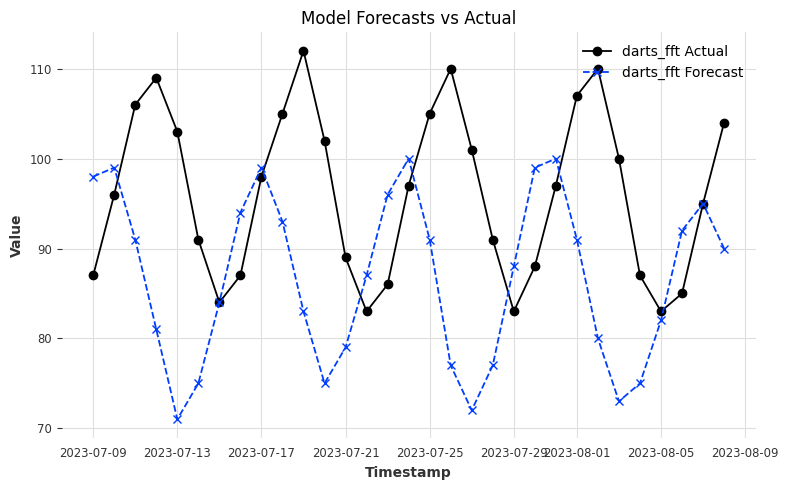

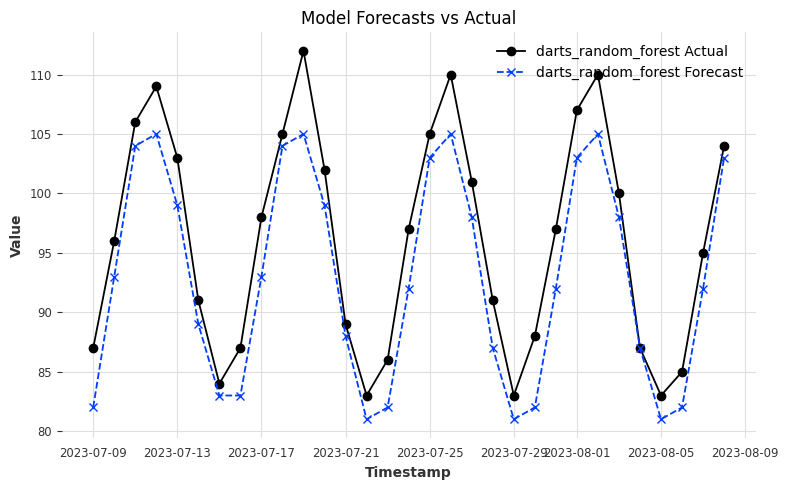

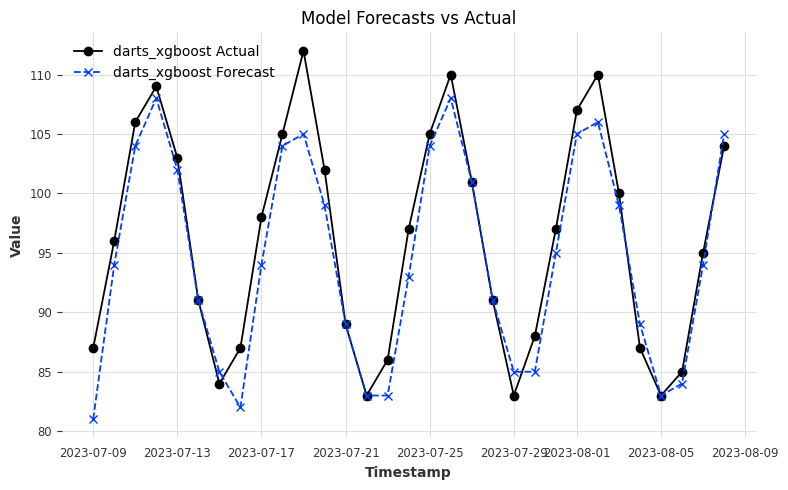

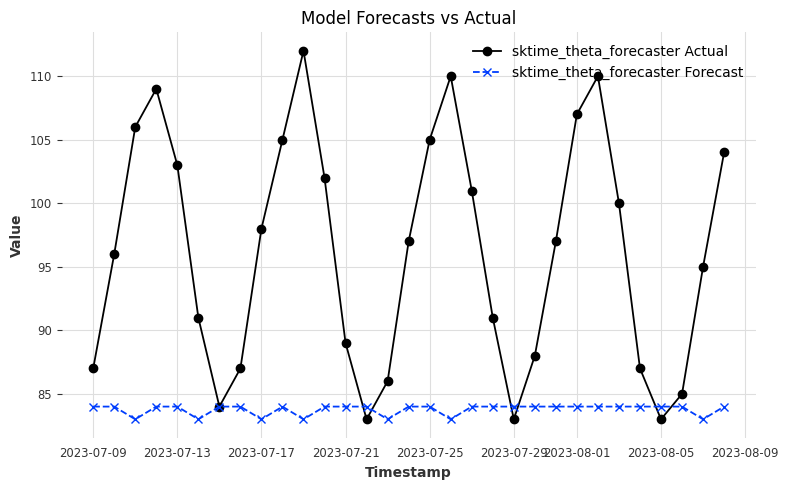

In [206]:
# Plotting each model's forecast vs actual
df_local['TIMESTAMP'] = pd.to_datetime(df_local['TIMESTAMP'])
df_local = df_local.sort_values(by=['TIMESTAMP']).reset_index(drop=True)

for model, group in df_local.groupby('MODEL_NAME'):
    plt.figure(figsize=(8, 5))
    plt.plot(group['TIMESTAMP'], group['VALUE'], label=f"{model} Actual", marker='o', linestyle='-')
    plt.plot(group['TIMESTAMP'], group['FORECAST'], label=f"{model} Forecast", marker='x', linestyle='--')

    plt.title('Model Forecasts vs Actual')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [210]:
df_mape = df_local.dropna(subset= 'FORECAST').reset_index(drop=True)

df_mape['APE'] = ((df_mape['VALUE'] - df_mape['FORECAST']).abs() / df_mape['VALUE']) * 100

# Calculating the mean absolute percentage error for each model
mape_per_model = df_mape.groupby('MODEL_NAME')['APE'].mean()

print(mape_per_model)

MODEL_NAME
darts_fft                  13.640673
darts_random_forest         3.336245
darts_xgboost               2.070194
sktime_theta_forecaster    12.286223
Name: APE, dtype: float64


# Deployment

1. Get the command to run the forecast function
2. Create a task
3. Resume task to run on the schedule

In [150]:
forecast_script = f'''
INSERT  INTO FORECAST  SELECT "PUMP_ID", "TIMESTAMP", "FORECAST", "MODEL_NAME", "TRAIN_START", "TRAIN_END",
"FORECAST_HORIZON", current_timestamp() AS "FORECAST_DATETIME" FROM ( SELECT T_LEFT.*, T_RIGHT."TIMESTAMP",
T_RIGHT."FORECAST", T_RIGHT."MODEL_NAME", T_RIGHT."TRAIN_START", T_RIGHT."TRAIN_END", T_RIGHT."FORECAST_HORIZON"
FROM ( SELECT "PUMP_ID", object_construct_keep_null(*) AS "ROW" FROM TIME_SERIES_DATA) AS T_LEFT JOIN  TABLE 
(TS_FORECASTING_MULTI(parse_json( CAST ("ROW" AS VARIANT))) OVER (PARTITION BY "PUMP_ID" )) AS T_RIGHT)
'''

task_script = f'''
CREATE OR REPLACE TASK POC_INVISTA.TASK_FORECAST_TS
WAREHOUSE = SSK_RESEARCH
SCHEDULE = '1 MINUTE'
AS {forecast_script};
'''

resume_script = f'''ALTER TASK POC_INVISTA.TASK_FORECAST_TS RESUME;'''

In [151]:
session.sql(task_script).collect()
# session.sql(resume_script).collect()

[Row(status='Task TASK_FORECAST_TS successfully created.')]